# Updated_Machine_Failure_Prediction.ipynb

An enhanced notebook for predicting machine failure with robust EDA,
hyperparameter tuning for multiple models, and MLflow experiment tracking.

## Core libraries for data manipulation and analysis

In [1]:
import pandas as pd
import numpy as np
import warnings

## Visualization libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

## Machine Learning libraries from scikit-learn

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

## Models

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

## MLflow for experiment tracking

In [5]:
import mlflow
import mlflow.sklearn

## Initial settings

In [6]:
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
get_ipython().run_line_magic('matplotlib', 'inline')

# 2. Data Loading and Initial Inspection

In [7]:
# Load the dataset
df = pd.read_csv('C:\\Users\\USER\\Downloads\\Maintenance\\predictive_maintenance.csv')

# Display the first few rows
print("First 5 rows of the dataset:")
display(df.head())

# Display basic information
print("\nDataset Information:")
df.info()

# Display summary statistics
print("\nSummary Statistics:")
display(df.describe())

# Check for missing values
print("\nMissing Values Check:")
print(df.isnull().sum())

First 5 rows of the dataset:


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB

Summary Statistics:


,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000



Missing Values Check:
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64


# 3. Robust Exploratory Data Analysis (EDA)

We'll dive deep to understand the data distributions, relationships, and potential issues like class imbalance.

In [8]:
# The 'UDI' and 'Product ID' columns are identifiers and won't be useful for modeling.
df_eda = df.drop(['UDI', 'Product ID'], axis=1)

### 3.1. Target Variable Analysis: Machine Failure
It's crucial to understand the distribution of our target variable.

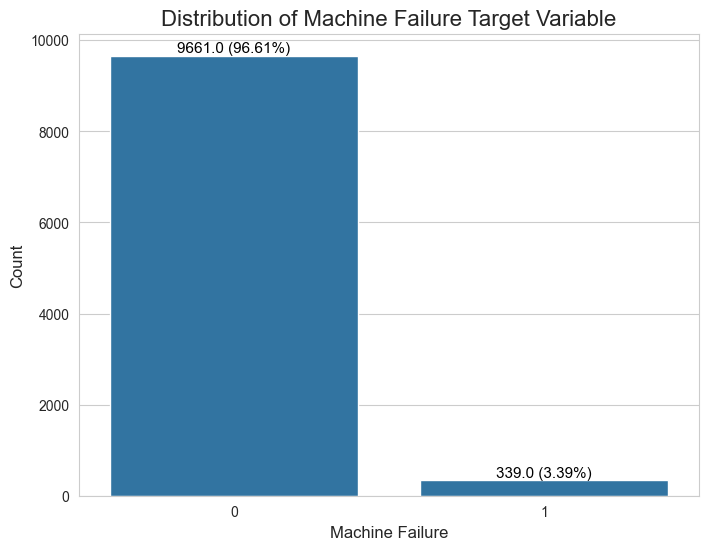

Insight: The dataset is highly imbalanced. Only ~3.4% of the data points represent a machine failure. This must be addressed during modeling, for example by using 'stratify' in train_test_split and focusing on metrics like F1-score and ROC AUC.


In [9]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Target', data=df_eda)
plt.title('Distribution of Machine Failure Target Variable', fontsize=16)
plt.xlabel('Machine Failure', fontsize=12)
plt.ylabel('Count', fontsize=12)
for p in ax.patches:
    ax.annotate(f'{p.get_height()} ({p.get_height()/len(df_eda)*100:.2f}%)',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

print("Insight: The dataset is highly imbalanced. Only ~3.4% of the data points represent a machine failure. This must be addressed during modeling, for example by using 'stratify' in train_test_split and focusing on metrics like F1-score and ROC AUC.")

### 3.2. Univariate Analysis (Distribution of individual features)

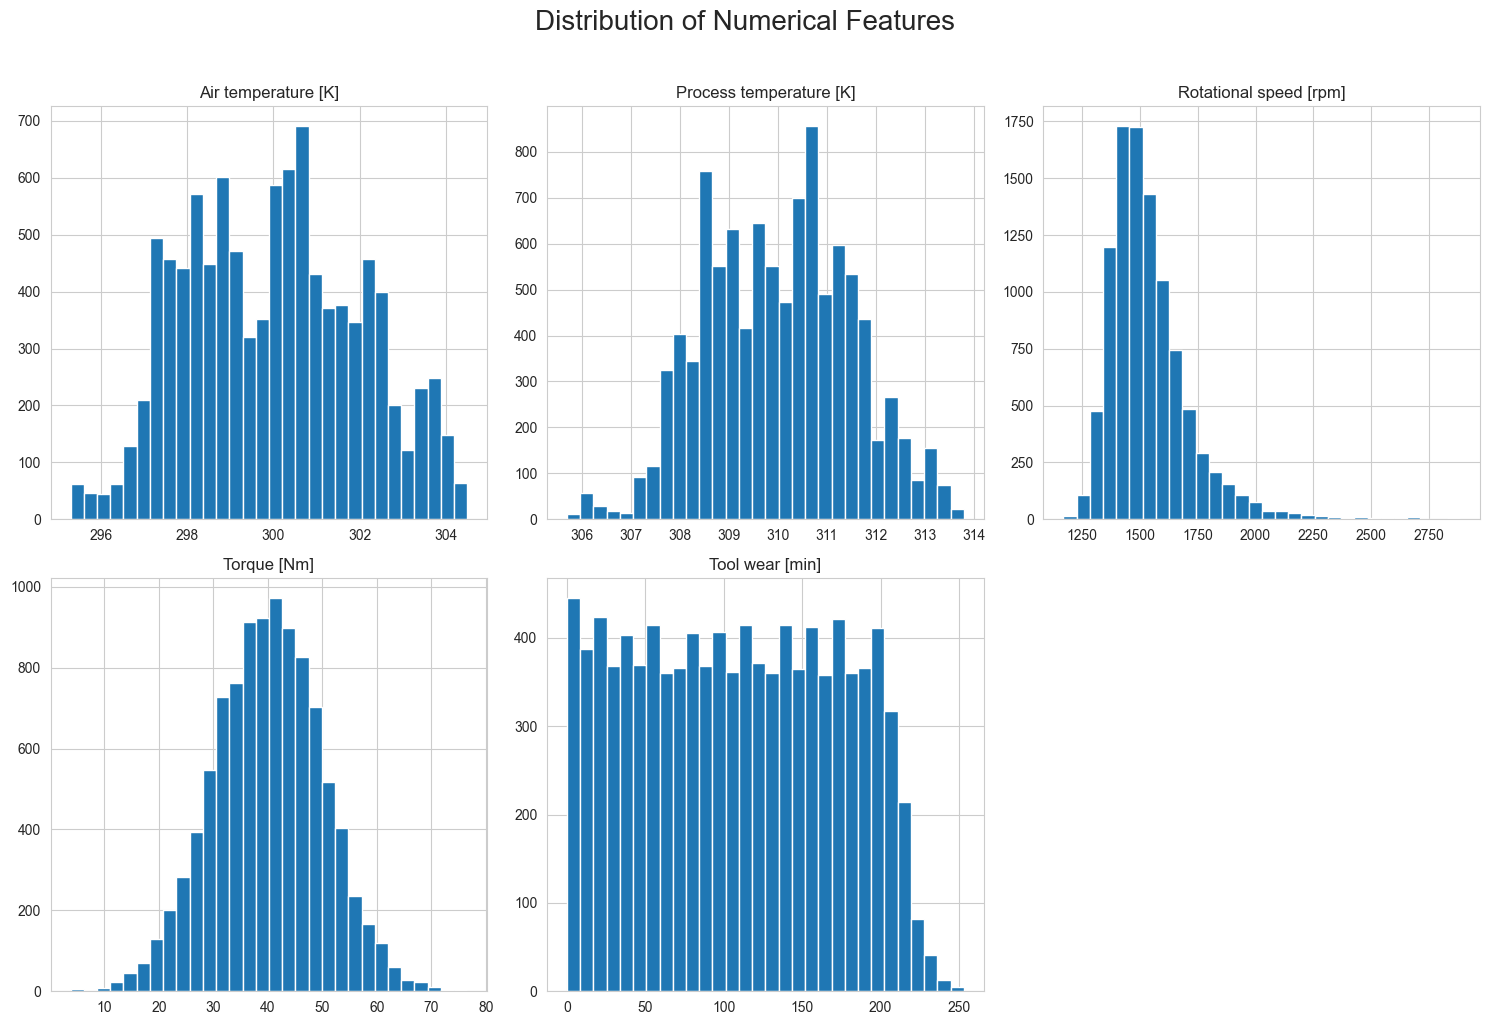

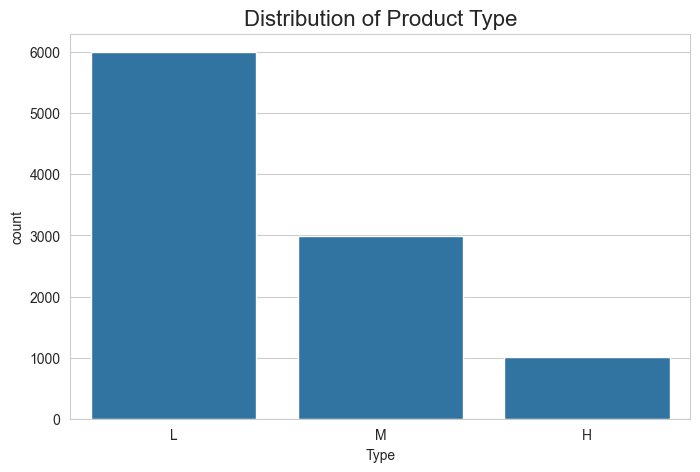

In [10]:
# Analyze numerical features
numerical_features = df_eda.select_dtypes(include=np.number).drop('Target', axis=1).columns.tolist()

df_eda[numerical_features].hist(bins=30, figsize=(15, 10), layout=(2, 3))
plt.suptitle('Distribution of Numerical Features', y=1.02, size=20)
plt.tight_layout()
plt.show()

# Analyze categorical features
categorical_features = df_eda.select_dtypes(include='object').columns.tolist()
plt.figure(figsize=(8, 5))
sns.countplot(x='Type', data=df_eda, order=df_eda['Type'].value_counts().index)
plt.title('Distribution of Product Type', fontsize=16)
plt.show()

### 3.3. Bivariate Analysis (Relationship between features and target)

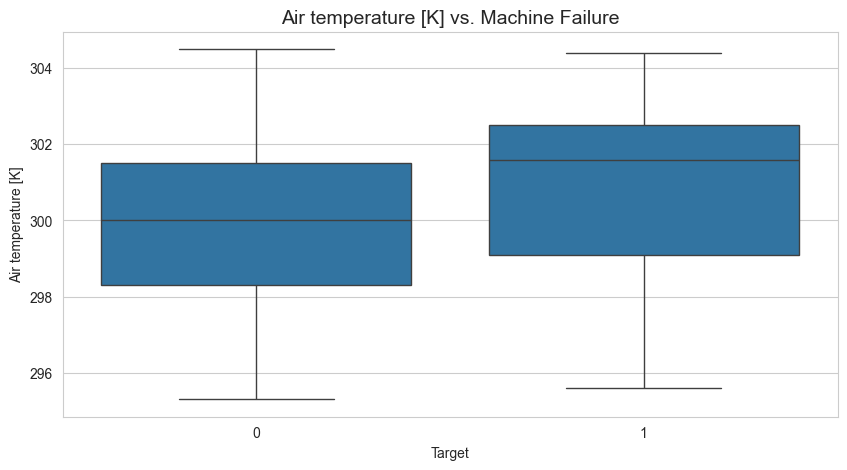

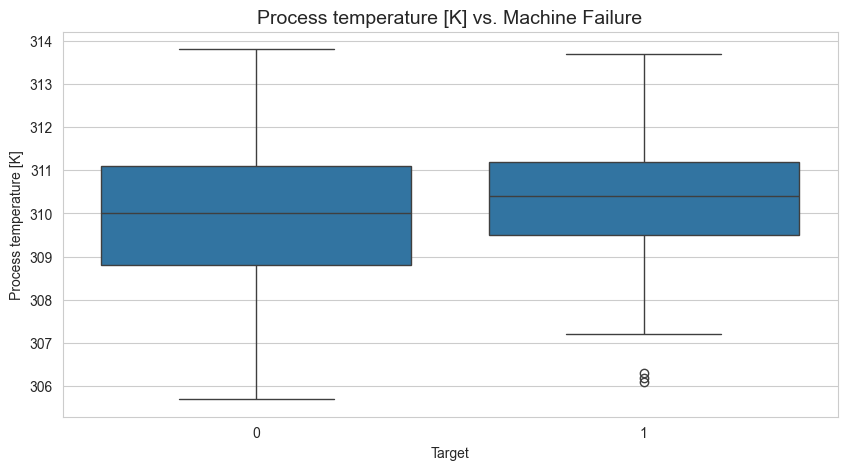

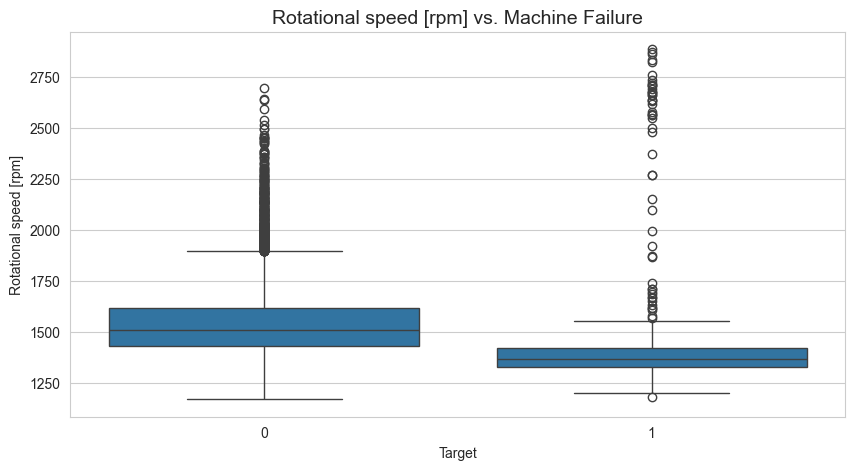

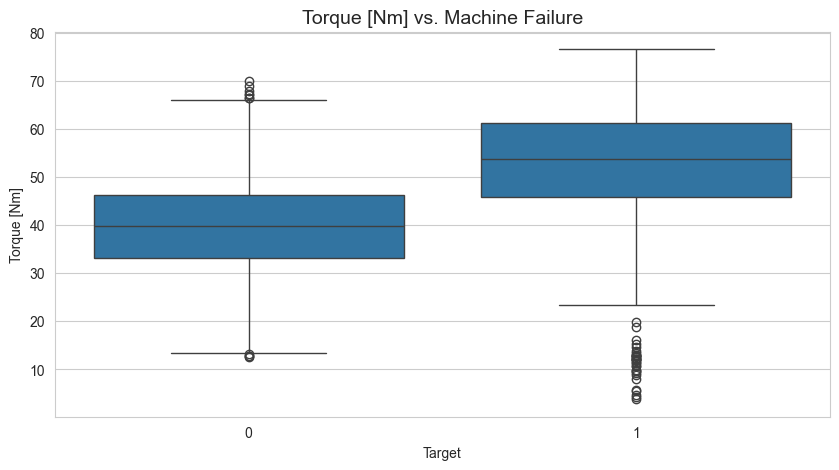

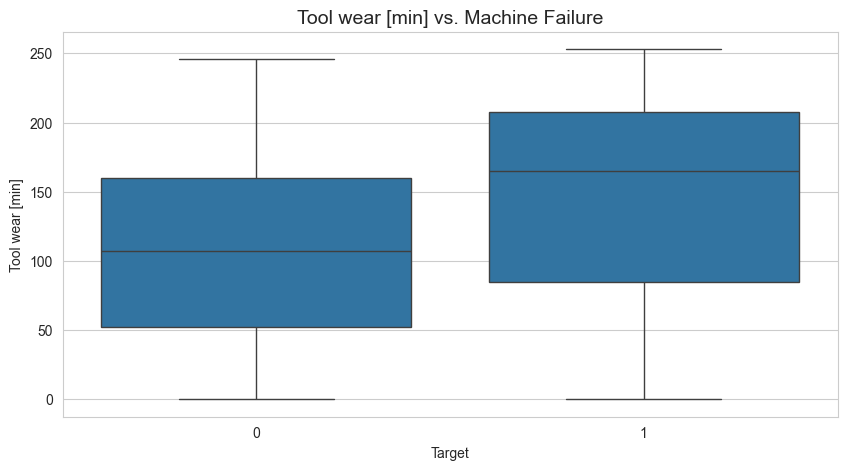

Insight: Features like 'Air temperature', 'Process temperature', and 'Rotational speed' show some difference in distribution between failure and non-failure cases. 'Torque' shows a very clear separation, making it a potentially strong predictor.


In [11]:
# Numerical features vs. Machine Failure
for col in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Target', y=col, data=df_eda)
    plt.title(f'{col} vs. Machine Failure', fontsize=14)
    plt.show()

print("Insight: Features like 'Air temperature', 'Process temperature', and 'Rotational speed' show some difference in distribution between failure and non-failure cases. 'Torque' shows a very clear separation, making it a potentially strong predictor.")

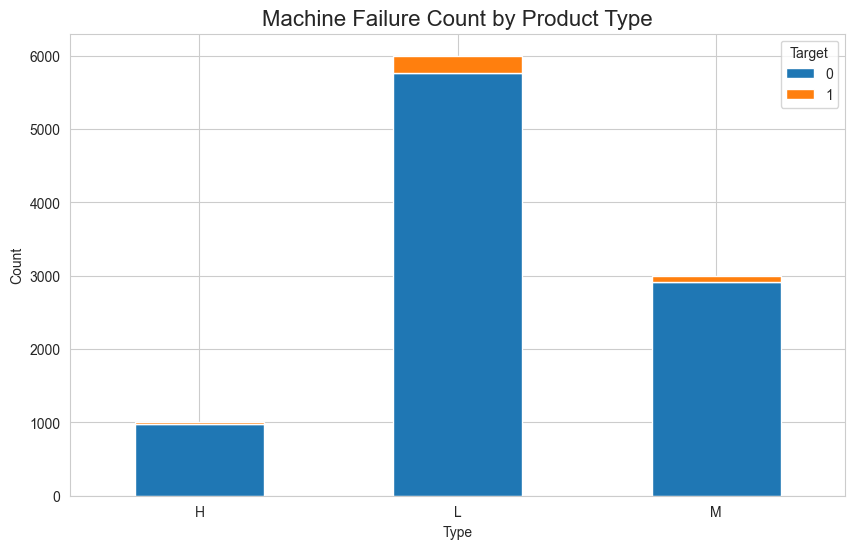

In [12]:
# Categorical feature 'Type' vs. Machine Failure
type_failure = pd.crosstab(df_eda['Type'], df_eda['Target'])
type_failure.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Machine Failure Count by Product Type', fontsize=16)
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### 3.4. Multivariate Analysis (Relationships between numerical features)

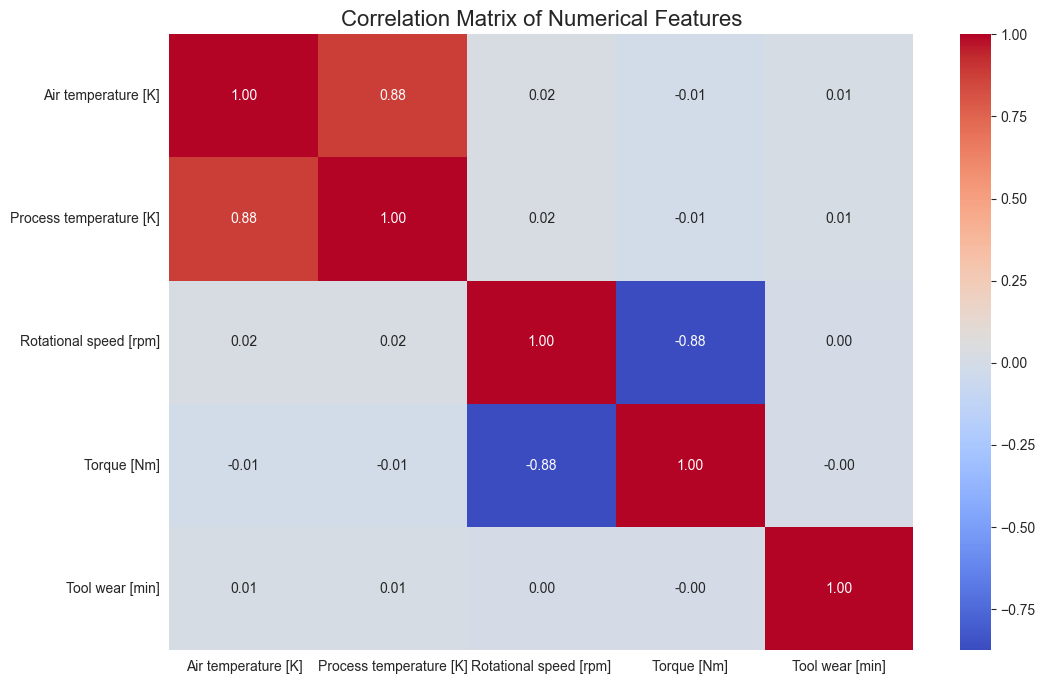

Insight: 'Process temperature' and 'Air temperature' have a strong positive correlation. 'Rotational speed' and 'Torque' have a strong negative correlation. This multicollinearity might affect some models (like Logistic Regression) but is less of an issue for tree-based models.


In [13]:
plt.figure(figsize=(12, 8))
corr_matrix = df_eda[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()

print("Insight: 'Process temperature' and 'Air temperature' have a strong positive correlation. 'Rotational speed' and 'Torque' have a strong negative correlation. This multicollinearity might affect some models (like Logistic Regression) but is less of an issue for tree-based models.")

# 4. Data Preprocessing

Prepare the data for modeling by splitting it and applying transformations like one-hot encoding for categorical data and scaling for numerical data.

In [14]:
# Define features (X) and target (y)
X = df.drop(['UDI', 'Product ID', 'Target'], axis=1)
y = df['Target']

# Identify categorical and numerical feature names
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

# Split the data into training and testing sets
# Using 'stratify=y' is important for imbalanced datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (8000, 7)
Testing set shape: (2000, 7)


# 5. Model Training and Experiment Tracking with MLflow

We will train and tune several models, logging everything with MLflow.

In [15]:
# Set the MLflow experiment
mlflow.set_experiment("Machine_Failure_Prediction_V2")

def train_and_log_model(model, params, model_name):
    """
    A helper function to train a model with GridSearchCV and log results to MLflow.
    """
    # Create the full pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Perform Grid Search
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Start MLflow run
    with mlflow.start_run(run_name=model_name):
        print(f"--- Training {model_name} ---")

        # Log best parameters and score
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Best F1-Score (CV): {grid_search.best_score_:.4f}")
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("best_cv_f1_score", grid_search.best_score_)

        # Evaluate the best model on the test set
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

        # Log metrics
        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Test Precision: {precision:.4f}")
        print(f"Test Recall: {recall:.4f}")
        print(f"Test F1-Score: {f1:.4f}")
        print(f"Test ROC AUC: {roc_auc:.4f}")

        metrics = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "roc_auc": roc_auc
        }
        mlflow.log_metrics(metrics)

        # Create and log confusion matrix as an artifact
        fig, ax = plt.subplots(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=ax, cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}')

        # Save the plot and log it
        cm_path = f"confusion_matrix_{model_name}.png"
        plt.savefig(cm_path)
        plt.close()
        mlflow.log_artifact(cm_path)

        # Log the model
        mlflow.sklearn.log_model(best_model, f"{model_name}_model")
        print(f"Model and artifacts for {model_name} logged successfully.\n")

    return grid_search.best_estimator_

2025/07/21 12:56:47 INFO mlflow.tracking.fluent: Experiment with name 'Machine_Failure_Prediction_V2' does not exist. Creating a new experiment.


### 5.1. Logistic Regression

In [16]:
# Define model and parameters for Grid Search
lr = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')
lr_params = {'classifier__C': [0.01, 0.1, 1, 10, 100]}

# Train and log
best_lr = train_and_log_model(lr, lr_params, 'LogisticRegression')

--- Training LogisticRegression ---
Best Parameters: {'classifier__C': 100}
Best F1-Score (CV): 0.9991
Test Accuracy: 0.9990
Test Precision: 1.0000
Test Recall: 0.9706
Test F1-Score: 0.9851
Test ROC AUC: 0.9725


2025/07/21 12:58:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model and artifacts for LogisticRegression logged successfully.



### 5.2. Decision Tree Classifier

In [17]:
# Define model and parameters for Grid Search
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_params = {
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Train and log
best_dt = train_and_log_model(dt, dt_params, 'DecisionTree')

--- Training DecisionTree ---
Best Parameters: {'classifier__max_depth': 15, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best F1-Score (CV): 0.9981
Test Accuracy: 0.9990
Test Precision: 1.0000
Test Recall: 0.9706
Test F1-Score: 0.9851
Test ROC AUC: 0.9853


2025/07/21 12:59:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model and artifacts for DecisionTree logged successfully.



### 5.3. Random Forest Classifier

In [18]:
# Define model and parameters for Grid Search
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
rf_params = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_leaf': [2, 5]
}

# Train and log
best_rf = train_and_log_model(rf, rf_params, 'RandomForest')

--- Training RandomForest ---
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 100}
Best F1-Score (CV): 0.9990
Test Accuracy: 0.9985
Test Precision: 0.9851
Test Recall: 0.9706
Test F1-Score: 0.9778
Test ROC AUC: 0.9868


2025/07/21 13:01:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model and artifacts for RandomForest logged successfully.



### 5.4. XGBoost Classifier

In [19]:
# XGBoost handles imbalanced data well with 'scale_pos_weight'
# Calculate scale_pos_weight for imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
xgb_params = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.05, 0.1]
}

# Train and log
best_xgb = train_and_log_model(xgb_model, xgb_params, 'XGBoost')

--- Training XGBoost ---
Best Parameters: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Best F1-Score (CV): 0.9991
Test Accuracy: 0.9990
Test Precision: 1.0000
Test Recall: 0.9706
Test F1-Score: 0.9851
Test ROC AUC: 0.9880


2025/07/21 13:01:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model and artifacts for XGBoost logged successfully.



# 6. Conclusion and Next Steps

The experiments have been successfully run and logged using MLflow.

**To view the results:**
1. Open a terminal or command prompt.
2. Navigate to the directory where this notebook is saved.
3. Run the command: `mlflow ui`
4. Open your web browser and go to `http://127.0.0.1:5000` (or the address shown in the terminal).

In the MLflow UI, you can compare the parameters and performance metrics of all the models (Logistic Regression, Decision Tree, Random Forest, XGBoost) side-by-side. You can also inspect the artifacts, such as the saved model files and confusion matrix plots, for each run.

**Summary of Findings:**
- The EDA revealed a significant class imbalance and highlighted 'Torque' as a key predictor.
- Tree-based models like Random Forest and XGBoost generally outperform simpler models due to their ability to capture complex non-linear relationships.
- By using MLflow, we have created a reproducible and organized machine learning workflow, making it easy to track progress and select the best-performing model for deployment.